In [29]:
stock_ = 'ONGC'

In [1]:
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [32]:
start = dt.datetime(2014,1,1)
end = dt.datetime(2019,12,31)
stk_data = gh(symbol=stock_,start=start,end=end)

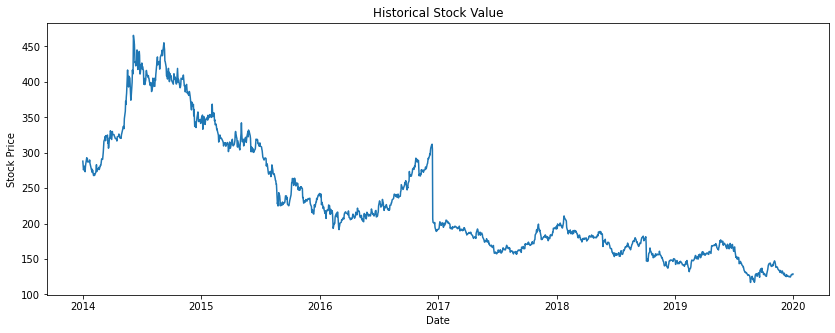

In [33]:
plt.figure(figsize=(14,5))
plt.plot(stk_data['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [34]:
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data2['Date'] = stk_data['Date']
data2['Open'] = stk_data['Open']
data2['High'] = stk_data['High']
data2['Low'] = stk_data['Low']
data2['Close'] = stk_data['Close']

In [35]:
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 1478):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [36]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [8]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 15, batch_size = 32, validation_split=0.2)

Epoch 1/15
36/36 [==============================] - 5s 149ms/step - loss: 0.0296 - val_loss: 0.0014
Epoch 2/15
36/36 [==============================] - 4s 111ms/step - loss: 0.0059 - val_loss: 8.3591e-04
Epoch 3/15
36/36 [==============================] - 4s 117ms/step - loss: 0.0046 - val_loss: 7.2253e-04
Epoch 4/15
36/36 [==============================] - 4s 117ms/step - loss: 0.0044 - val_loss: 5.4330e-04
Epoch 5/15
36/36 [==============================] - 4s 110ms/step - loss: 0.0042 - val_loss: 5.5731e-04
Epoch 6/15
36/36 [==============================] - 4s 106ms/step - loss: 0.0037 - val_loss: 5.8127e-04
Epoch 7/15
36/36 [==============================] - 4s 114ms/step - loss: 0.0040 - val_loss: 4.6815e-04
Epoch 8/15
36/36 [==============================] - 4s 112ms/step - loss: 0.0041 - val_loss: 5.1925e-04
Epoch 9/15
36/36 [==============================] - 4s 113ms/step - loss: 0.0041 - val_loss: 4.8467e-04
Epoch 10/15
36/36 [==============================] - 4s 113ms/step -

In [37]:
regressor.save('saved_models/{}_pre'.format(stock_))

INFO:tensorflow:Assets written to: saved_models/ONGC_pre\assets


In [42]:
testdataframe= gh(symbol=stock_,start=dt.datetime(2020,1,1),end=dt.datetime(2020,8,31))
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
#upper limit is number of days - 25
for i in range(60, 218):          
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [43]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

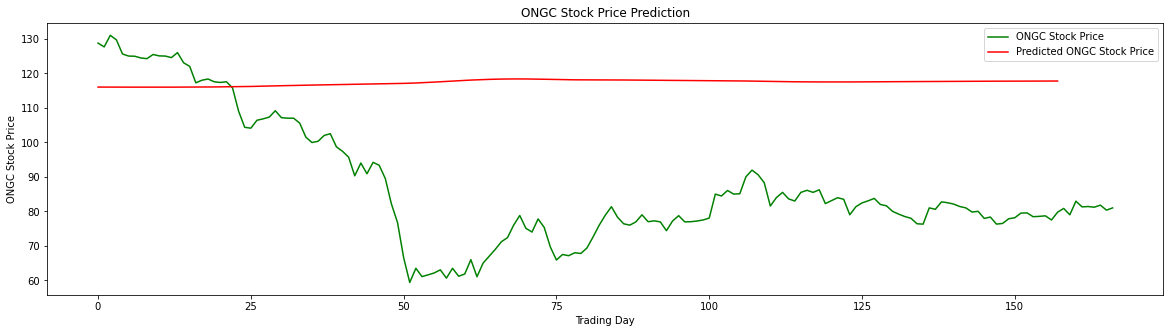

In [44]:
plt.figure(figsize=(20,5))
plt.plot(real_stock_price, color = 'green', label = '{} Stock Price'.format(stock_))
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted {} Stock Price'.format(stock_))
plt.title('{} Stock Price Prediction'.format(stock_))
plt.xlabel('Trading Day')
plt.ylabel('{} Stock Price'.format(stock_))
plt.legend()
plt.show()